# Phase space tomography

Primer for using phase space tomography tool

In [1]:
%load_ext autoreload
from preprocess import Preprocess
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tomo_plot import Plot
from reconstruct import Reconstruct
from track import Lattice, Model
import utils


import pickle
plt.rcParams['image.cmap'] = 'jet'

Import sinograms measured in AWAKE. 

In [2]:

with open('my_sinox', 'rb') as f:
    data = pickle.load(f)

projectionsx = data['sinogram']
ksx = data['ks']

with open('my_sinoy', 'rb') as f:
    data = pickle.load(f)

projectionsy = data['sinogram']
ksy = data['ks']

# with open('input_data', 'rb') as f:
#     data = pickle.load(f)

# beam = data['beam']
# projectionsy = data['sino_y'].T
# projectionsx = data['sino_x'].T
# ksx = data['ksx']
# ksy = data['ksy'] 



In [3]:
# fig, axs = plt.subplots(1, 2)
# axs[0].hist2d(beam[:,0], beam[:,1], bins=128)
# axs[0].set_xlabel('x (mm)')
# axs[0].set_ylabel('x\' (mrad)')
# # axs[0].set_xlim(-0.3, 0.3)
# axs[0].set_ylabel('x\' (mrad)')
# axs[1].hist2d(beam[:,2], beam[:,3], bins=128)
# axs[0].set_xlabel('y (mm)')
# axs[0].set_ylabel('y\' (mrad)')
%autoreload
sequence = {'quad':(0.0708,10), 'drift':(0.831693)}
lattice = Lattice(sequence)
lattice.create_lattice()

# for k in ksx:
#     sequence = {'quad':(0.0708,k), 'drift':(0.831693)}
#     M = create_lattice(sequence)

# lattice.add_quadrupole()
# lattice.add_drift



array([[ 0.39110975,  0.88114503,  0.        ,  0.        ],
       [-0.70209989,  0.97504132,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.61893845,  0.92401808],
       [ 0.        ,  0.        ,  0.71392976,  1.02516807]])

Now it is time to preprocess the data to make them ready for tomography

In [14]:
%autoreload
sequence = {'quad':[0.0708,10], 'drift':[0.831693]}

processx = Preprocess(projectionsx, ksx, sequence, plane='x', norm=[0.4, 0.6])
processy = Preprocess(projectionsy, ksy, sequence, plane='y', norm=[0.4, 0.6])


TypeError: 'tuple' object does not support item assignment

In [13]:
%autoreload
processx.ks

array([-40.99, -40.91, -39.58, -36.86, -36.74, -36.73, -32.59, -32.48,
       -32.47, -28.34, -28.21, -24.08, -23.95, -23.94, -19.82, -19.69,
       -19.68, -15.54, -15.42, -15.41, -11.28, -11.15,  -7.02,  -6.9 ,
        -6.89,  -2.75,  -2.63,   1.51,   1.63,   5.76,   5.89,   7.28,
         7.29,   7.33,   8.31,  10.15,  10.16,  14.29,  14.41,  14.42,
        18.56,  18.68,  22.82,  22.94,  22.95,  27.08,  27.2 ,  27.21,
        31.34,  31.46,  31.47,  35.61,  35.73,  39.87,  39.99,  40.  ])

the process instance is used as input for reconstruction

In [11]:
%autoreload
recx = Reconstruct(processx)
recy = Reconstruct(processy)

dist_x = recx.MLEM(100)
dist_y = recy.MLEM(100)

[autoreload of track failed: Traceback (most recent call last):
  File "c:\Users\vbencini\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\vbencini\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "c:\Users\vbencini\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 347, in update_generic
    update(a, b)
  File "c:\Users\vbencini\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "c:\Users\vbencini\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 347, in update_generic
    update(a, b)
  File "c:\Users\vbencini\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name))
ValueError: __init__() requires a code

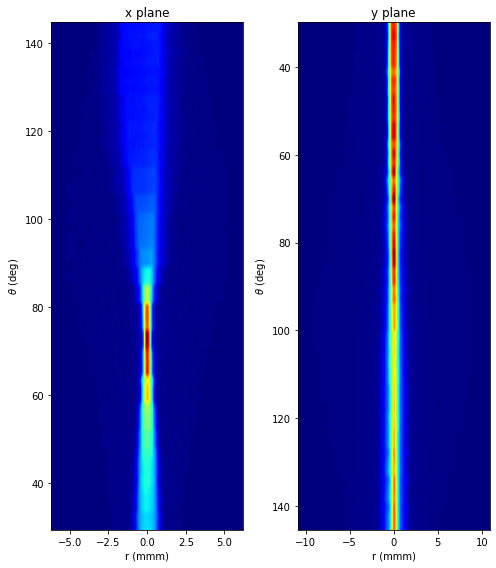

(<Figure size 504x576 with 2 Axes>,
 array([ <AxesSubplot:title={'center':'x plane'}, xlabel='r (mmm)', ylabel='$\\theta$ (deg)'>,
        <AxesSubplot:title={'center':'y plane'}, xlabel='r (mmm)', ylabel='$\\theta$ (deg)'>], dtype=object))

In [12]:
%autoreload
pl = Plot(processx, processy, dist_x, dist_y)
# Plot scaled sinograms

pl.plot_sino_scale()


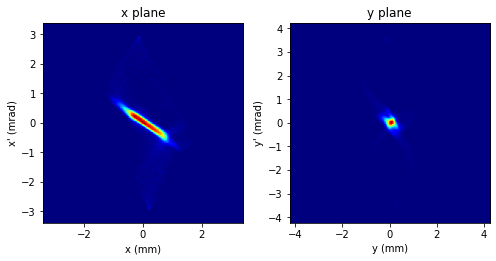

(<Figure size 504x576 with 2 Axes>,
 array([ <AxesSubplot:title={'center':'x plane'}, xlabel='x (mm)', ylabel="x' (mrad)">,
        <AxesSubplot:title={'center':'y plane'}, xlabel='y (mm)', ylabel="y' (mrad)">], dtype=object))

In [13]:
pl.plot_reconstructed()

Let's generate a distribution from the reconstructed images

In [94]:
dist_x_part = utils.gen_dist(dist_x, 10000, processx.x_new)
dist_y_part = utils.gen_dist(dist_y, 10000, processy.x_new)

dist_x_part_unnorm = utils.apply(processx.Vi,dist_x_part)
dist_y_part_unnorm = utils.apply(processx.Vi,dist_y_part)


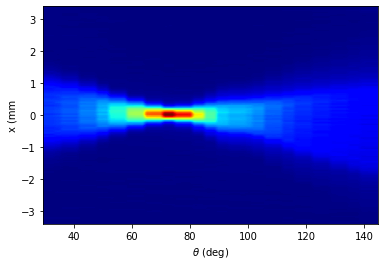

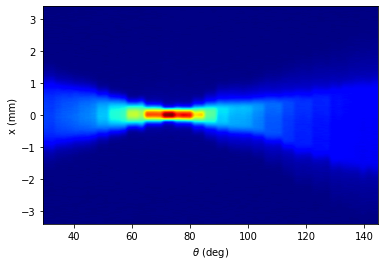

In [95]:
projections,_ = utils.track(dist_x_part_unnorm, processx.thetas, 'x', processx.x_new, processx.Vi, n_bins=128)
proj_trackx = utils.norm_image(projections)
plt.imshow(proj_trackx, origin = 'lower',extent=[processx.thetas[0], processx.thetas[-1], processx.x_new[0], processx.x_new[-1]],  aspect = 'auto', vmax=1)
plt.xlabel('$\\theta$ (deg)')
plt.ylabel('x (mm')
plt.savefig('proj_track_x.png', dpi=300)

plt.figure()
# plt.imshow(np.array(projections), origin = 'lower',extent=[thetas[0], thetas[-1], x[0], x[-1]],  aspect = 'auto', vmax=1)
plt.imshow(utils.norm_image(processx.unscaled_projections).T, origin = 'lower',extent=[processx.thetas[0], processx.thetas[-1], processx.x_new[0], processx.x_new[-1]],  aspect = 'auto', vmax = 1)
plt.xlabel('$\\theta$ (deg)')
plt.ylabel('x (mm)')
plt.savefig('proj_orig_x.png', dpi=300)

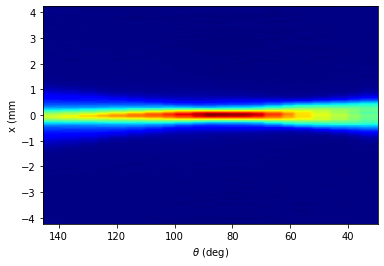

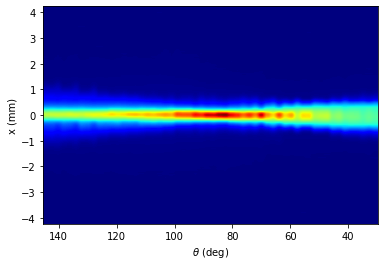

In [97]:
projections,_ = utils.track(dist_y_part_unnorm, processy.thetas, 'y', processy.x_new, processy.Vi, n_bins=128)
proj_tracky = utils.norm_image(projections)
plt.imshow(proj_tracky, origin = 'lower',extent=[processy.thetas[0], processy.thetas[-1], processy.x_new[0], processy.x_new[-1]],  aspect = 'auto', vmax=1)
plt.xlabel('$\\theta$ (deg)')
plt.ylabel('x (mm')
plt.savefig('proj_track_x.png', dpi=300)

plt.figure()
# plt.imshow(np.array(projections), origin = 'lower',extent=[thetas[0], thetas[-1], x[0], x[-1]],  aspect = 'auto', vmax=1)
plt.imshow(utils.norm_image(processy.unscaled_projections).T, origin = 'lower',extent=[processy.thetas[0], processy.thetas[-1], processy.x_new[0], processy.x_new[-1]],  aspect = 'auto', vmax = 1)
plt.xlabel('$\\theta$ (deg)')
plt.ylabel('x (mm)')
plt.savefig('proj_orig_x.png', dpi=300)

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([-0.17156359, -0.16876524, -0.16596689, -0.16316854, -0.16037019,
        -0.15757185, -0.1547735 , -0.15197515, -0.1491768 , -0.14637845,
        -0.1435801 , -0.14078175, -0.13798341, -0.13518506, -0.13238671,
        -0.12958836, -0.12679001, -0.12399166, -0.12119331, -0.11839497,
        -0.11559662, -0.11279827, -0.10999992, -0.10720157, -0.10440322,
        -0.10160487, -0.09880653, -0.09600818, -0.09320983, -0.09041148,
        -0.08761313, -0.08481478, -0.08201643, -0.07921809, -0.07641974,
        -0.07362139, -0.07082304, -0.06802469, -0.06522634, -0.06242799,
        -0.05962965, -0.0568313 , -0.05403295, -0.0512346 , -0.04843625,
        -0.0456379 , -0.04283955, -0.04004121, -0.0372428

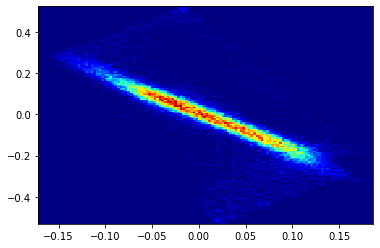

In [75]:
plt.hist2d(dist_x_part_unnorm[:,0],dist_x_part_unnorm[:,1], bins=128)

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([-1.04444419, -1.02600251, -1.00756083, -0.98911914, -0.97067746,
        -0.95223577, -0.93379409, -0.9153524 , -0.89691072, -0.87846904,
        -0.86002735, -0.84158567, -0.82314398, -0.8047023 , -0.78626061,
        -0.76781893, -0.74937725, -0.73093556, -0.71249388, -0.69405219,
        -0.67561051, -0.65716883, -0.63872714, -0.62028546, -0.60184377,
        -0.58340209, -0.5649604 , -0.54651872, -0.52807704, -0.50963535,
        -0.49119367, -0.47275198, -0.4543103 , -0.43586861, -0.41742693,
        -0.39898525, -0.38054356, -0.36210188, -0.34366019, -0.32521851,
        -0.30677682, -0.28833514, -0.26989346, -0.25145177, -0.23301009,
        -0.2145684 , -0.19612672, -0.17768504, -0.1592433

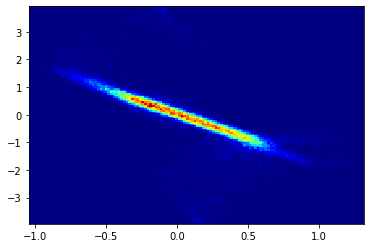

In [84]:
plt.hist2d(beam[:,0],beam[:,1], bins=128, )

0.64